In [1]:
import cellpose
# from nd2reader import ND2Reader
import mitoanalysis

In [2]:
def nd2_opener(fname):
    metadata = {}
    with ND2Reader(fname) as imagestack:
        pixelres = imagestack.metadata["pixel_microns"]
        metadata["axes"] = ["t", "c", "y", "x"]  # imagestack.axes
        metadata["pixel_unit"] = "um"
        metadata["pixel_res"] = pixelres
        metadata[
            "scale"
        ] = f"{1/metadata['pixel_res']} pixels per {metadata['pixel_unit']}"
        # set order tcyx and convert to np array
        try:
            imagestack.bundle_axes = "cyx"
            imagestack.iter_axes = "t"
            imagestack = np.array(imagestack)
        except:
            imagestack.bundle_axes = "yx"
            imagestack.iter_axes = "t"
            imagestack = np.array(imagestack)
            imagestack = np.expand_dims(imagestack, axis=1)
        metadata["shape"] = {
            metadata["axes"][i]: imagestack.shape[i] for i in range(len(imagestack.shape))
        }
    print(f"metadata['shape']={metadata['shape']}")
    print(f"imagestack.shape={imagestack.shape}")
    return imagestack, metadata

In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt
from cellpose import models, io
from cellpose.io import imread

io.logger_setup()

# model_type='cyto' or 'nuclei' or 'cyto2' or 'cyto3'
model = models.Cellpose(gpu=True, model_type='cyto3')

# list of files
# PUT PATH TO YOUR FILES HERE!
path = '/scratch/khs3z/mitosisanalyzer/data/New_files_tracking/partially_worked'
file = os.path.join(path, '20240322_MAS91_hcp6RNAi_48hRT006.nd2')
#file = "/standard/redemann_lab/raw_data/New_files_tracking/20240322_MAS91_hcp6RNAi_48hRT003.nd2"

imgstack,meta = mitoanalysis.nd2_opener(file)
nimg = 1
t=len(imgstack)//2
ch=0
imgslice = imgstack[t]
print(imgslice.shape)
imgslice = np.median(imgstack, axis=0)

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
channels = [[0,0]]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended)
# diameter can be a list or a single number for all images

masks, flows, styles, diams = model.eval([imgslice], diameter=157, channels=channels, cellprob_threshold=1.0)

2024-12-04 18:28:41,875 [INFO] WRITING LOG OUTPUT TO /home/khs3z/.cellpose/run.log
2024-12-04 18:28:41,876 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.10.13 
torch version:  	2.2.1
2024-12-04 18:28:41,895 [INFO] ** TORCH CUDA version installed and working. **
2024-12-04 18:28:41,896 [INFO] >>>> using GPU
2024-12-04 18:28:41,897 [INFO] >> cyto3 << model set to be used
2024-12-04 18:28:41,947 [INFO] >>>> loading model /home/khs3z/.cellpose/models/cyto3
2024-12-04 18:28:41,996 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
metadata['shape']={'t': 210, 'c': 2, 'y': 512, 'x': 512}
imagestack.shape=(210, 2, 512, 512)
(2, 512, 512)
2024-12-04 18:29:19,481 [INFO] channels set to [[0, 0]]
2024-12-04 18:29:19,482 [INFO] ~~~ FINDING MASKS ~~~
2024-12-04 18:29:19,799 [INFO] >>>> TOTAL TIME 0.32 sec


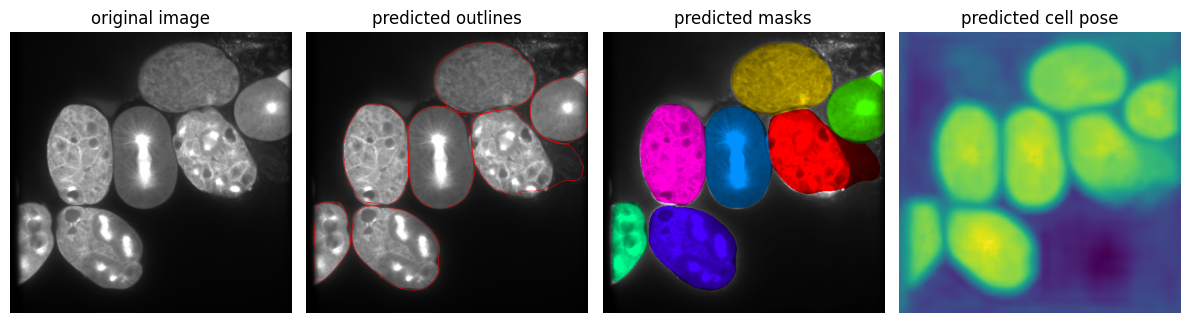

In [26]:
# DISPLAY RESULTS
from cellpose import plot


fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, imgslice[ch], masks[0], flows[0][2], channels=channels)
plt.tight_layout()
plt.show()

In [22]:
new_img = np.where(masks[0] > 0, img, 0)

NameError: name 'img' is not defined

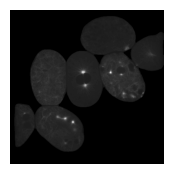

In [5]:
plt.figure(figsize=(2,2))
plt.imshow(new_img, cmap="gray")
plt.axis('off')
plt.show()